<a href="https://colab.research.google.com/github/Shaielyfs/analise_geoespacial/blob/main/AnaliseGeoespacial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ANÁLISES GEOESPACIAIS COM RASTERS

In [ ]:
#instalar bibliotecas
!pip install rasterio -q

In [ ]:
#importar bibliotecas
import geopandas as gpd
import pandas as pd
import zipfile
import requests
import json
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt

import rasterio
from rasterio.transform import from_origin
from rasterio.mask import mask
from rasterio.features import shapes, rasterize
from rasterio.warp import calculate_default_transform, reproject, Resampling

from scipy.ndimage import rotate
from scipy.spatial import distance_matrix
from scipy.ndimage import gaussian_filter

In [ ]:
#descompactar o arquivo Topodata
with zipfile.ZipFile('/content/drive/MyDrive/analise_geoespacial_part2/07S36_ZN.zip', 'r') as zip_ref:
    zip_ref.extractall('07S36_ZN')

#descompactar o arquivo municipios
with zipfile.ZipFile('/content/drive/MyDrive/analise_geoespacial_part2/PB_Municipios_2022.zip)', 'r') as zip_ref:
    zip_ref.extractall('PB_Municipios_2022')

<Axes: >

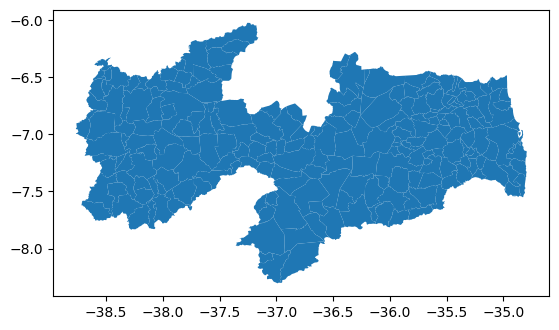

In [ ]:
#ler dados shape
municipios = gpd.read_file('/content/PB_Municipios_2022/PB_Municipios_2022.shp')
plot 'PB_Municipios_2022.shp'

<Axes: >

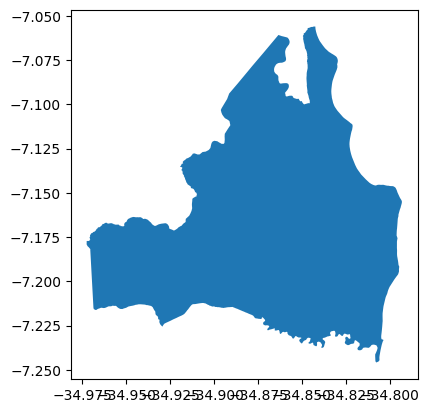

In [ ]:
#selecionar municipio
municipio_especifico = municipios[municipios['NM_MUN'] == 'João Pessoa']
municipio_especifico.plot()
#

In [ ]:
#carregar o raster recortado
with rasterio.open('/content/07S36_ZN/07S36_ZN.tif') as src:   #abrir uma imagem rasterio
  out_image, out_transform = mask(src, municipio_especifico.geometry, crop=True)

  #remove a primeira dimensao se ela tem tamanho 1
  out_image = out_image.squeese()

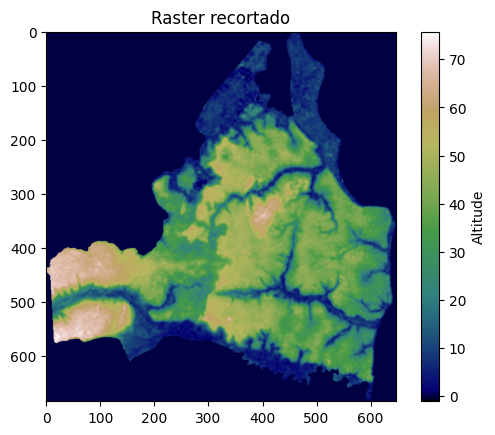

In [ ]:
#vizualizar a imagem
plt.imshow(out_image, cmap='earth')
plt.colorbar(label='Altitude')
plt.title("Raster recortado")
plt.show()

In [ ]:
#reclassificar o raster
reclassified = np.copy(out_image)  #nova variavel criando copia do arquivo
reclassified[(out_image >= 0) & (out_image <= 10)] = 1  #do pixel 0 a 10 classificar como 1
reclassified[(out_image > 10) & (out_image <= 20)] = 2
reclassified[(out_image > 20) & (out_image <= 30)] = 3
reclassified[(out_image > 30) & (out_image <= 50)] = 4
reclassified[(out_image > 50) & (out_image <= 70)] = 5
reclassified[(out_image > 70) & (out_image <= 80)] = 6
reclassified[(out_image > 80) & (out_image <= 90)] = 7
reclassified[(out_image > 90) & (out_image <= 100)] = 8


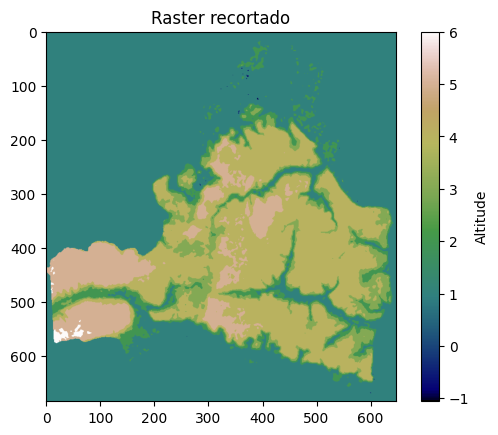

In [ ]:
#agora out_image_squeezed tem a forma
plt.imshow(reclassified, cmap='gist_earth')
plt.colorbar(label='Altitude')
plt.title("Raster recortado")
plt.show()

In [ ]:
#sistema de referencia de destino
dest_crs = 'EPSG:4326' #wgs 84

In [ ]:
# ABRIR o raster original
with rasterio.open('/content/07S36_ZN/07S36_ZN.tif') as src:
  transform, width, height = calculate_default_transform(
      src.crs, dest_crs, src.width, src.height, *src.bounds)

#parametros do novo dataset
kwargs = src.meta.copy()  #copiar o meta dado dessa imagem e salvar no dicionario
kwargs.update({
    'crs': dest_crs,
    'transform': transform,
    'width': width,
    'height': height
})

#criar e salvar o raster reprojetado
with rasterio.open('/content/07S36_ZN_reprojected.tif', 'w', **kwargs) as dst:
  for i in range(1, src.count + 1):
    reproject(
        source=rasterio.band(src, i),
        destination=rasterio.band(dst, i),
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=dest_crs,
        resampling=Resampling.nearest
    )



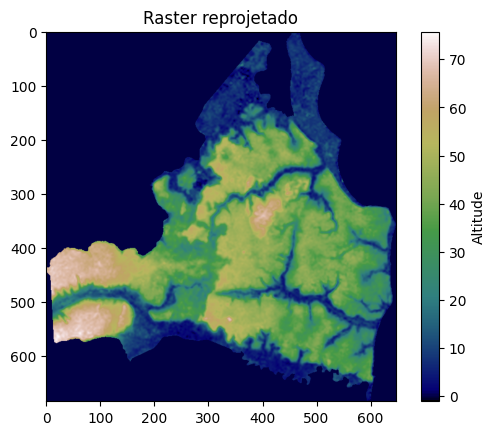

In [ ]:
##abrir a imagem reprojetada
with rasterio.open('/content/07S36_ZN_reprojected.tif') as src:   #abrir uma imagem rasterio
  out_image, out_transform = mask(src, municipio_especifico.geometry, crop=True)

#remove a primera dimensão se ela tem tamanho 1
out_image = out_image.squeeze()

#vizualizar
plt.imshow(out_image, cmap='gist_earth')
plt.colorbar(label='Altitude')
plt.title("Raster reprojetado")
plt.show()